# Plot Figure 10

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import netCDF4 as nc
import os

# Handy metpy tutorial working with xarray:
# https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#sphx-glr-tutorials-xarray-tutorial-py
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
from metpy.plots import SkewT

In [189]:
files = os.listdir("data/")
files

['CNRM-CM6-1-historical.nc']

In [190]:
ps = 100000 * units.Pa # temporary hack, should interpolate pressure from daily timeseries

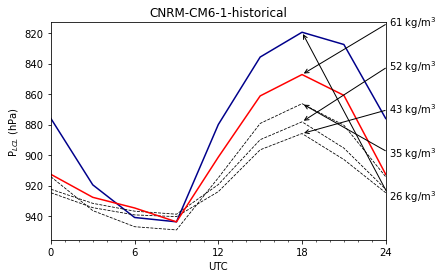

In [203]:
for data in files:
    # open the data and re-convert time to cftime so xarray is happy
    data_in = xr.open_dataset(f"data/{data}", engine="netcdf4", decode_times=False).metpy.quantify()
    data_in["time"] = cftime.num2date(data_in.time, "hours since 1850-01-01 00:00:00", calendar="noleap", has_year_zero=True)
    
    # use metpy to convert humidity field to dew point temp
    data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)

    # compute the spatial average
    spatial_average = data_in.mean(dim=("lat", "lon"))

    # sort the file into 6 groups based on soil moisture content
    the_max = float(spatial_average.mrsos.max().values)
    the_min = float(spatial_average.mrsos.min().values)
    the_range =  the_max - the_min

    spatial_average["soil_moisture_grp"] = ((spatial_average.mrsos / (the_range / 6)).round() * (the_range / 6)).round()

    gbysoil = spatial_average.groupby(spatial_average.soil_moisture_grp)
    
    # remove the highest and lowest values, they are usually too sparse to plot
    mrsos_keys = list(gbysoil.groups.keys())
    mrsos_keys.remove(max(mrsos_keys))
    mrsos_keys.remove(min(mrsos_keys))
    
    # calculate and plot the average diurnal cycle of lcl height
    fig, ax = plt.subplots()
    lposition = 0 # for annotating plot
    for key in mrsos_keys:
        # group by hour
        hourly_data = gbysoil[key].groupby(gbysoil[key].time.dt.hour).mean(dim="time") 

        # find and plot the lcl
        plcl, tlcl = mpcalc.lcl(ps, hourly_data.tas, hourly_data.td)
        plcl_hpa = plcl / 100
        

        if key == min(mrsos_keys):
            plot_kwargs = {"color":"darkblue"}
        elif key == max(mrsos_keys):
            plot_kwargs = {"color":"red"}
        else:
            plot_kwargs = {"color":"black", "linestyle":"--", "linewidth":0.8}

        # append hour 24 to match hour 0
        the_time = np.append(hourly_data.hour.values, 24)
        the_lcl = np.append(plcl_hpa, plcl_hpa[0])
        ax.plot(the_time, the_lcl, **plot_kwargs)
        
        
        #the_label = ax.annotate(f"{round(key)} kg/m$^3$", (24, the_lcl[-1]))
        lposition += 1 / 5
        ax.annotate(f"{round(key)} kg/m$^3$",
                    xy=(18, the_lcl[-3]), xycoords='data',
                    xytext=(1.01, lposition), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="->", relpos=(0,0.5)),
                    horizontalalignment='left', verticalalignment='center')

    # make the plot match Betts fig 11
    plt.gca().invert_yaxis()
    ax.set_xlabel("UTC")
    ax.set_ylabel("P$_{LCL}$ (hPa)")
    #ax.axvline(21, color="k", linewidth=1)
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks((0,6,12,18,24))
    ax.set_xlim(0,24)
    ax.set_title(data[:-3]);
